In [1]:
import torch
from torch import nn
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
class Linear(torch.nn.Module):
  def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
    factory_kwargs = {'device': device, 'dtype': dtype}
    super(Linear, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = nn.Parameter(torch.empty((out_features, in_features), **factory_kwargs))
    if bias:
        self.bias = nn.Parameter(torch.empty(out_features, **factory_kwargs))
    else:
        self.register_parameter('bias', None)
    self.reset_parameters()

  def reset_parameters(self) -> None:
    self.weight = nn.Parameter(torch.rand([self.out_features, self.in_features]))
    if self.bias is not None:
      self.bias = nn.Parameter(torch.rand([self.out_features]))

  def forward(self, input: torch.Tensor) -> torch.Tensor:
    return torch.matmul(input, torch.transpose(self.weight,0,1)) + self.bias

  def extra_repr(self) -> str:
    return 'in_features={}, out_features={}, bias={}'.format(
        self.in_features, self.out_features, self.bias is not None
      )


In [4]:
class BTU(torch.nn.Module):
  def __init__(self, T=0.2, inplace: bool = False):
      super(BTU, self).__init__()
      self.T = T

  def forward(self, input: torch.Tensor) -> torch.Tensor:
      return 1 / (1 + torch.exp(-input/self.T))

In [5]:
class XOR_Net_Model(nn.Module):
  def __init__(self,dim=2,num_hidden=4,bypass=True):
    super().__init__()
    self.dim = dim
    self.num_hidden = num_hidden
    self.bypass = bypass
    self.hidden = Linear(self.dim,  self.num_hidden)
    if self.bypass:
      self.output = Linear( self.num_hidden + self.dim, 1)
    else:
      self.output = Linear( self.num_hidden, 1)
    self.BTU = BTU(0.5)

  def forward(self, input):
    z1 = self.hidden(input)
    y1 = self.BTU(z1)
    if self.bypass:
      y1_concat = torch.cat((input, y1), 1)
      z2 = self.output(y1_concat)
    else:
      z2 = self.output(y1)
    return self.BTU(z2)

In [6]:
def Loss(out, t_train):
  return -torch.sum(t_train * torch.log(out) + (1.0 - t_train) * torch.log(1.0 - out))/out.size()[0]  # Cross Entropy loss function


In [7]:
x_train = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], requires_grad=True, dtype=torch.float32)
t_train = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)
x_val =  torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1],[1,0.1],[1,0.9],[0.9,0.9],[0.1,0.9]], requires_grad=True, dtype=torch.float32)
t_val = torch.tensor([[0], [1], [1], [0],[1],[0],[0],[1]], dtype=torch.float32)

In [8]:
def train(model, x_train, t_train, optimizer):
  y_pred = model(x_train)
  loss = Loss(y_pred, t_train)

  # zero gradients berfore running the backward pass
  optimizer.zero_grad()

  # backward pass to compute the gradient of loss
  # backprop + accumulate
  loss.backward()

  # update params
  optimizer.step()
  return loss

In [9]:
def create_optimizer(model, lr):
    return torch.optim.SGD(model.parameters(), lr=lr)

In [10]:
def train_and_evaluate(optimizer, model, x_train, t_train, x_val, t_val, num_epochs=40000):
    history = {"train_loss": [], "val_loss": []}  # Initialize history dictionary
    consecutive_successful_epochs = 0
    max_consecutive_epochs = 10

    for epoch in range(num_epochs):
        # Training step
        train_loss = train(model, x_train, t_train, optimizer)
        history["train_loss"].append(train_loss.item())

        # Validation step
        with torch.no_grad():
            y_val_pred = model(x_val)
            val_loss = Loss(y_val_pred, t_val).item()
            history["val_loss"].append(val_loss)

        # Print progress every 5000 epochs
        if epoch % 5000 == 0:
            print(f"Epoch: {epoch}, Train Loss: {train_loss.item():.6f}, Validation Loss: {val_loss:.6f}")

        # Check stopping condition 1
        if len(history["val_loss"]) >= 10:
            recent_losses = history["val_loss"][-10:]
            if all(loss < 0.2 for loss in recent_losses):
                consecutive_successful_epochs += 1
            else:
                consecutive_successful_epochs = 0

        if consecutive_successful_epochs >= max_consecutive_epochs:
            print("\nTraining stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.")
            break

        # Check stopping condition 2
        if epoch + 1 >= num_epochs:
            print("\nTraining stopped: Reached maximum allowed epochs.")
            break

    # Return final history
    return history




# 9 diffrent hyper parmeters

In [11]:
num_epocs = 40000

In [12]:
#1 : l_rate: 0.1, hidden = 4, bypass = false

model1 = XOR_Net_Model(2,4,False)
optimizer = torch.optim.SGD(model1.parameters(), lr=0.1)
train_and_evaluate(optimizer,model1,x_train,t_train,x_val,t_val,num_epocs)

Epoch: 0, Train Loss: 2.208795, Validation Loss: 1.899559

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.


{'train_loss': [2.208794593811035,
  1.8571417331695557,
  1.533239483833313,
  1.251319169998169,
  1.0278419256210327,
  0.8727713823318481,
  0.7804889678955078,
  0.7326017618179321,
  0.7099587917327881,
  0.6997520923614502,
  0.695215106010437,
  0.693170428276062,
  0.6922042369842529,
  0.6917018890380859,
  0.6913987994194031,
  0.6911813020706177,
  0.6910006999969482,
  0.6908361315727234,
  0.690678596496582,
  0.6905243396759033,
  0.6903715133666992,
  0.690219521522522,
  0.6900681257247925,
  0.6899169087409973,
  0.6897660493850708,
  0.6896152496337891,
  0.6894646883010864,
  0.6893141269683838,
  0.6891638040542603,
  0.6890133619308472,
  0.6888631582260132,
  0.6887128353118896,
  0.6885625123977661,
  0.6884121894836426,
  0.6882617473602295,
  0.6881113052368164,
  0.687960684299469,
  0.687809944152832,
  0.6876590251922607,
  0.6875079870223999,
  0.68735671043396,
  0.6872052550315857,
  0.6870535016059875,
  0.6869013905525208,
  0.6867490410804749,
  0.686

In [13]:
#2 : l_rate: 0.1, hidden = 2, bypass = False

model2 = XOR_Net_Model(2,2,False)
optimizer = create_optimizer(model2, lr=0.1)
train_and_evaluate(optimizer,model2,x_train,t_train,x_val,t_val,num_epocs)

Epoch: 0, Train Loss: 1.422863, Validation Loss: 1.306267

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.


{'train_loss': [1.422863483428955,
  1.2389552593231201,
  1.0821400880813599,
  0.9560974836349487,
  0.861372709274292,
  0.794867217540741,
  0.7509292960166931,
  0.7232646942138672,
  0.7064271569252014,
  0.6963934898376465,
  0.6904770135879517,
  0.6869933605194092,
  0.6849263906478882,
  0.6836771368980408,
  0.6828974485397339,
  0.6823863983154297,
  0.6820287704467773,
  0.6817585229873657,
  0.6815381050109863,
  0.6813459992408752,
  0.681169867515564,
  0.6810027360916138,
  0.6808406114578247,
  0.6806812882423401,
  0.6805234551429749,
  0.6803661584854126,
  0.680209219455719,
  0.6800521612167358,
  0.6798951625823975,
  0.6797376871109009,
  0.6795800924301147,
  0.67942214012146,
  0.6792638301849365,
  0.6791051626205444,
  0.6789461374282837,
  0.6787866353988647,
  0.6786267757415771,
  0.6784664988517761,
  0.6783057451248169,
  0.6781445741653442,
  0.6779831051826477,
  0.6778210401535034,
  0.6776584982872009,
  0.6774954199790955,
  0.6773319840431213,
  0

In [14]:
#3 : l_rate: 0.1, hidden = 4, bypass = True

model3 = XOR_Net_Model(2,4,True)
optimizer = create_optimizer(model3, lr=0.1)
train_and_evaluate(optimizer,model3,x_train,t_train,x_val,t_val,num_epocs)

Epoch: 0, Train Loss: 3.228366, Validation Loss: 3.227956

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.


{'train_loss': [3.228365898132324,
  2.794950485229492,
  2.3728604316711426,
  1.9698669910430908,
  1.599754810333252,
  1.2833682298660278,
  1.0431780815124512,
  0.8890588283538818,
  0.8073845505714417,
  0.7705228924751282,
  0.7551572322845459,
  0.748532772064209,
  0.745169997215271,
  0.7429879307746887,
  0.7412430047988892,
  0.7396764159202576,
  0.73819899559021,
  0.7367798089981079,
  0.7354077100753784,
  0.7340781688690186,
  0.7327888011932373,
  0.7315380573272705,
  0.7303247451782227,
  0.7291475534439087,
  0.7280054092407227,
  0.7268972396850586,
  0.725821852684021,
  0.7247785329818726,
  0.7237659692764282,
  0.7227831482887268,
  0.721829354763031,
  0.7209035158157349,
  0.720004677772522,
  0.7191320657730103,
  0.7182846665382385,
  0.7174617648124695,
  0.7166624665260315,
  0.7158859968185425,
  0.7151317596435547,
  0.7143987417221069,
  0.7136862874031067,
  0.7129937410354614,
  0.7123205065727234,
  0.7116657495498657,
  0.7110288739204407,
  0.71

In [15]:
#4 : l_rate: 0.1, hidden = 2, bypass = True

model4 = XOR_Net_Model(2,2,True)
optimizer = create_optimizer(model4, lr=0.1)
train_and_evaluate(optimizer,model4,x_train,t_train,x_val,t_val,num_epocs)

Epoch: 0, Train Loss: 2.645718, Validation Loss: 2.529969

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.


{'train_loss': [2.6457178592681885,
  2.344907760620117,
  2.0522048473358154,
  1.7720119953155518,
  1.5112308263778687,
  1.2794159650802612,
  1.0871853828430176,
  0.9420843124389648,
  0.8438965678215027,
  0.7840876579284668,
  0.750497579574585,
  0.7324983477592468,
  0.7229641675949097,
  0.7177939414978027,
  0.7148168683052063,
  0.7129343152046204,
  0.7116023898124695,
  0.7105549573898315,
  0.7096619606018066,
  0.7088601589202881,
  0.708118200302124,
  0.7074203491210938,
  0.7067583203315735,
  0.7061276435852051,
  0.7055253982543945,
  0.7049495577812195,
  0.7043987512588501,
  0.7038715481758118,
  0.7033668160438538,
  0.7028836011886597,
  0.7024207711219788,
  0.7019774317741394,
  0.70155268907547,
  0.7011456489562988,
  0.7007555961608887,
  0.7003815174102783,
  0.7000229358673096,
  0.6996788382530212,
  0.6993487477302551,
  0.6990319490432739,
  0.6987278461456299,
  0.6984357833862305,
  0.6981552243232727,
  0.6978855729103088,
  0.6976264119148254,
 

In [16]:
#5 : l_rate: 0.01, hidden = 4, bypass = false

model5 = XOR_Net_Model(2,4,False)
optimizer = create_optimizer(model5, lr=0.01)
train_and_evaluate(optimizer,model5,x_train,t_train,x_val,t_val,num_epocs)

Epoch: 0, Train Loss: 2.210887, Validation Loss: 2.352969
Epoch: 5000, Train Loss: 0.414107, Validation Loss: 0.498802

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.


{'train_loss': [2.2108869552612305,
  2.1766867637634277,
  2.142685651779175,
  2.1088900566101074,
  2.0753068923950195,
  2.0419445037841797,
  2.00880765914917,
  1.975905418395996,
  1.9432525634765625,
  1.9108529090881348,
  1.8787175416946411,
  1.8468523025512695,
  1.8152737617492676,
  1.7839908599853516,
  1.7530103921890259,
  1.722346544265747,
  1.6920112371444702,
  1.6620166301727295,
  1.6323716640472412,
  1.603090524673462,
  1.5741870403289795,
  1.545671820640564,
  1.5175576210021973,
  1.4898582696914673,
  1.4625864028930664,
  1.4357531070709229,
  1.4093730449676514,
  1.3834559917449951,
  1.358016014099121,
  1.333064079284668,
  1.30861234664917,
  1.284670114517212,
  1.2612488269805908,
  1.2383580207824707,
  1.2160062789916992,
  1.1942018270492554,
  1.17295241355896,
  1.152263879776001,
  1.1321423053741455,
  1.1125917434692383,
  1.0936156511306763,
  1.0752166509628296,
  1.0573954582214355,
  1.0401524305343628,
  1.0234862565994263,
  1.0073944

In [17]:
#6 : l_rate: 0.01, hidden = 2, bypass = False

model6 = XOR_Net_Model(2,2,False)
optimizer = create_optimizer(model6, lr=0.01)
train_and_evaluate(optimizer,model6,x_train,t_train,x_val,t_val,num_epocs)

Epoch: 0, Train Loss: 1.425620, Validation Loss: 1.421932
Epoch: 5000, Train Loss: 0.692317, Validation Loss: 0.692244
Epoch: 10000, Train Loss: 0.658072, Validation Loss: 0.667415
Epoch: 15000, Train Loss: 0.434119, Validation Loss: 0.503961
Epoch: 20000, Train Loss: 0.374232, Validation Loss: 0.460562
Epoch: 25000, Train Loss: 0.361607, Validation Loss: 0.449537
Epoch: 30000, Train Loss: 0.356683, Validation Loss: 0.444855
Epoch: 35000, Train Loss: 0.354126, Validation Loss: 0.442288

Training stopped: Reached maximum allowed epochs.


{'train_loss': [1.4256196022033691,
  1.4073641300201416,
  1.3893316984176636,
  1.3715262413024902,
  1.353953242301941,
  1.336615800857544,
  1.3195183277130127,
  1.3026645183563232,
  1.2860581874847412,
  1.269702672958374,
  1.2536020278930664,
  1.2377591133117676,
  1.2221770286560059,
  1.2068586349487305,
  1.191807508468628,
  1.1770250797271729,
  1.162514567375183,
  1.1482775211334229,
  1.1343162059783936,
  1.1206319332122803,
  1.1072264909744263,
  1.0941004753112793,
  1.0812547206878662,
  1.068690299987793,
  1.0564069747924805,
  1.0444051027297974,
  1.032684326171875,
  1.0212438106536865,
  1.0100829601287842,
  0.9992009401321411,
  0.9885959625244141,
  0.9782664775848389,
  0.9682104587554932,
  0.958425760269165,
  0.9489102363586426,
  0.9396608471870422,
  0.93067467212677,
  0.9219489097595215,
  0.9134798645973206,
  0.9052643775939941,
  0.8972983360290527,
  0.8895779848098755,
  0.8820991516113281,
  0.8748579025268555,
  0.867849588394165,
  0.861

In [18]:
#7 : l_rate: 0.01, hidden = 4, bypass = True

model7 = XOR_Net_Model(2,4,True)
optimizer = create_optimizer(model7, lr=0.01)
train_and_evaluate(optimizer,model7,x_train,t_train,x_val,t_val,num_epocs)

Epoch: 0, Train Loss: 2.422749, Validation Loss: 2.752676
Epoch: 5000, Train Loss: 0.206241, Validation Loss: 0.258000

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.


{'train_loss': [2.422748565673828,
  2.3840413093566895,
  2.345515012741089,
  2.307190179824829,
  2.2690768241882324,
  2.2311975955963135,
  2.1935348510742188,
  2.156128168106079,
  2.118964195251465,
  2.0820672512054443,
  2.0454421043395996,
  2.0090997219085693,
  1.9730560779571533,
  1.9373247623443604,
  1.9019105434417725,
  1.86683988571167,
  1.8321150541305542,
  1.797760248184204,
  1.7637826204299927,
  1.7302030324935913,
  1.697037935256958,
  1.6642990112304688,
  1.6320059299468994,
  1.600172996520996,
  1.5688204765319824,
  1.5379596948623657,
  1.5076130628585815,
  1.4777939319610596,
  1.4485177993774414,
  1.4198040962219238,
  1.391666054725647,
  1.364119052886963,
  1.3371782302856445,
  1.310856819152832,
  1.2851676940917969,
  1.2601227760314941,
  1.2357335090637207,
  1.2120094299316406,
  1.1889585256576538,
  1.1665891408920288,
  1.1449054479599,
  1.1239126920700073,
  1.1036126613616943,
  1.084007740020752,
  1.0650968551635742,
  1.046877384

In [19]:
#8 : l_rate: 0.01, hidden = 2, bypass = True

model8 = XOR_Net_Model(2,2,True)
optimizer = create_optimizer(model8, lr=0.01)
train_and_evaluate(optimizer,model8,x_train,t_train,x_val,t_val,num_epocs)

Epoch: 0, Train Loss: 1.708907, Validation Loss: 2.077641
Epoch: 5000, Train Loss: 0.199028, Validation Loss: 0.248686

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.


{'train_loss': [1.708906888961792,
  1.6866114139556885,
  1.6645466089248657,
  1.6427137851715088,
  1.6211185455322266,
  1.5997633934020996,
  1.5786616802215576,
  1.5578079223632812,
  1.53721284866333,
  1.516875147819519,
  1.4968032836914062,
  1.4770007133483887,
  1.4574685096740723,
  1.4382131099700928,
  1.4192395210266113,
  1.400546669960022,
  1.3821414709091187,
  1.3640282154083252,
  1.3462073802947998,
  1.328681230545044,
  1.311456561088562,
  1.2945315837860107,
  1.2779120206832886,
  1.2615962028503418,
  1.2455910444259644,
  1.229893684387207,
  1.2145085334777832,
  1.199435830116272,
  1.1846764087677002,
  1.1702313423156738,
  1.1561002731323242,
  1.1422837972640991,
  1.128781795501709,
  1.115593433380127,
  1.1027182340621948,
  1.0901565551757812,
  1.077905297279358,
  1.0659632682800293,
  1.0543301105499268,
  1.0430017709732056,
  1.0319774150848389,
  1.021253228187561,
  1.0108277797698975,
  1.0006968975067139,
  0.9908579587936401,
  0.98130

In [20]:
#9 : l_rate: 0.01, hidden = 1, bypass = True

model9 = XOR_Net_Model(2,1,True)
optimizer = create_optimizer(model9, lr=0.01)
train_and_evaluate(optimizer,model9,x_train,t_train,x_val,t_val,num_epocs)

Epoch: 0, Train Loss: 0.994327, Validation Loss: 1.124595
Epoch: 5000, Train Loss: 0.693107, Validation Loss: 0.693040
Epoch: 10000, Train Loss: 0.693017, Validation Loss: 0.692882
Epoch: 15000, Train Loss: 0.692162, Validation Loss: 0.691885
Epoch: 20000, Train Loss: 0.628297, Validation Loss: 0.639502
Epoch: 25000, Train Loss: 0.176559, Validation Loss: 0.223680

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.


{'train_loss': [0.9943267703056335,
  0.9861054420471191,
  0.9780591130256653,
  0.9701861143112183,
  0.962485671043396,
  0.9549558162689209,
  0.9475955367088318,
  0.9404031038284302,
  0.9333769679069519,
  0.9265152215957642,
  0.9198163747787476,
  0.9132780432701111,
  0.9068989753723145,
  0.9006765484809875,
  0.8946092128753662,
  0.8886945843696594,
  0.8829308152198792,
  0.8773154616355896,
  0.871846079826355,
  0.8665209412574768,
  0.8613370656967163,
  0.8562926054000854,
  0.8513848781585693,
  0.846611738204956,
  0.8419702053070068,
  0.8374583721160889,
  0.8330737352371216,
  0.8288133144378662,
  0.8246749639511108,
  0.8206562995910645,
  0.8167544603347778,
  0.8129672408103943,
  0.8092919588088989,
  0.8057261109352112,
  0.80226731300354,
  0.7989130020141602,
  0.7956607341766357,
  0.7925081253051758,
  0.7894526720046997,
  0.786491870880127,
  0.7836236953735352,
  0.7808454036712646,
  0.7781548500061035,
  0.7755496501922607,
  0.7730276584625244,
  

In [21]:
models = [
    {"l_rate": 0.1, "hidden": 4, "bypass": False},
    {"l_rate": 0.1, "hidden": 2, "bypass": False},
    {"l_rate": 0.1, "hidden": 4, "bypass": True},
    {"l_rate": 0.1, "hidden": 2, "bypass": True},
    {"l_rate": 0.01, "hidden": 4, "bypass": False},
    {"l_rate": 0.01, "hidden": 2, "bypass": False},
    {"l_rate": 0.01, "hidden": 4, "bypass": True},
    {"l_rate": 0.01, "hidden": 2, "bypass": True},
    {"l_rate": 0.01, "hidden": 1, "bypass": True},
]

# משתנים לאחסון תוצאות
results = []

# קריטריון הצלחה לדוגמה
def success_criterion(val_loss, threshold=0.2):
    return val_loss < threshold

# לולאה על המודלים
for model_idx, params in enumerate(models, start=1):
    print(f"\nStarting Model #{model_idx}: l_rate={params['l_rate']}, hidden={params['hidden']}, bypass={params['bypass']}")
    successes = 0
    attempts = 0
    train_losses = []
    val_losses = []
    epochs_to_success = []
    max_attempts = 50

    while successes < 10 and attempts < max_attempts:
        # בניית המודל
        model = XOR_Net_Model(2, params["hidden"], params["bypass"])
        optimizer = torch.optim.SGD(model.parameters(), lr=params["l_rate"])

        # אימון המודל
        history = train_and_evaluate(optimizer, model, x_train, t_train, x_val, t_val, num_epocs)
        train_loss = history["train_loss"]  # רשימת ה-Train Loss לכל אפוק
        val_loss = history["val_loss"]  # רשימת ה-Validation Loss לכל אפוק

        # בדיקת הצלחה
        final_val_loss = val_loss[-1]
        attempts += 1
        if success_criterion(final_val_loss):
            successes += 1
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            epochs_to_success.append(len(val_loss))  # מספר האפוקים עד עצירה
            print(f"Success {successes}/10 (epochs: {len(val_loss)})")
        else:
            print(f"Failure (attempt {attempts}, val_loss: {final_val_loss:.4f})")

    # חישוב נתונים סטטיסטיים לכל מודל
    avg_train_loss = np.mean([loss[-1] for loss in train_losses])
    avg_val_loss = np.mean([loss[-1] for loss in val_losses])
    avg_epochs = np.mean(epochs_to_success)
    std_epochs = np.std(epochs_to_success)

    # שמירת התוצאות
    results.append({
        "model": f"Model #{model_idx}",
        "avg_train_loss": avg_train_loss,
        "avg_val_loss": avg_val_loss,
        "avg_epochs": avg_epochs,
        "std_epochs": std_epochs,
        "attempts": attempts,
        "successes": successes,
    })

# הדפסת התוצאות
print("\nFinal Results:")
for result in results:
    print(f"{result['model']}:")
    print(f"  Average Train Loss: {result['avg_train_loss']:.4f}")
    print(f"  Average Validation Loss: {result['avg_val_loss']:.4f}")
    print(f"  Average Epochs to Success: {result['avg_epochs']:.2f} ± {result['std_epochs']:.2f}")
    print(f"  Total Attempts: {result['attempts']}")
    print(f"  Total Successes: {result['successes']}")
    print()



Starting Model #1: l_rate=0.1, hidden=4, bypass=False
Epoch: 0, Train Loss: 1.695559, Validation Loss: 1.483004

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.
Success 1/10 (epochs: 1181)
Epoch: 0, Train Loss: 1.769296, Validation Loss: 1.488559

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.
Success 2/10 (epochs: 892)
Epoch: 0, Train Loss: 2.252077, Validation Loss: 1.998150

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.
Success 3/10 (epochs: 1017)
Epoch: 0, Train Loss: 1.677762, Validation Loss: 1.502728

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.
Success 4/10 (epochs: 831)
Epoch: 0, Train Loss: 1.718778, Validation Loss: 1.503172

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.
Success 5/10 (epochs: 734)
Epoch: 0, Train Loss: 2.318022, Validation Loss: 2.050851

Training stopped successfully: Validation loss < 0.2 f

# סעיף ו

In [22]:
def print_hidden_neuron_outputs(model, x_train):
    """
    Prints the hidden neurons' output for the given input values from the training set.
    """
    # Check if the model or input data is missing
    if model is None or x_train is None:
        print("Error: Model or input data is missing.")
        return

    with torch.no_grad():
        # Pass the input data through the model's hidden layer to calculate the hidden layer output
        hidden_layer_output = model.hidden(x_train)
        hidden_layer_output = torch.sigmoid(hidden_layer_output)  # Apply the activation function

    # Print the hidden neurons' output alongside the input values
    print("Truth Table: Hidden Neuron Output vs. Input Values on Training Set")
    for i, input_values in enumerate(x_train):
        input_np = input_values.detach().cpu().numpy()  # Convert tensor to a NumPy array on CPU
        output_np = hidden_layer_output[i].detach().cpu().numpy()  # Convert tensor to a NumPy array on CPU
        print(f"Input: {input_np}, Hidden Output: {output_np}")

# Build a new model (or use a pre-trained one)
model_9 = XOR_Net_Model(2, 1, True)  # Model #9
optimizer_9 = torch.optim.SGD(model_9.parameters(), lr=0.1)

# Train the model
train_and_evaluate(optimizer_9, model_9, x_train, t_train, x_val, t_val, num_epocs)

# Print the hidden neurons' output for the training set
print_hidden_neuron_outputs(model_9, x_train)


Epoch: 0, Train Loss: 1.775128, Validation Loss: 1.806844
Epoch: 5000, Train Loss: 0.692755, Validation Loss: 0.692617

Training stopped successfully: Validation loss < 0.2 for 10 consecutive epochs.
Truth Table: Hidden Neuron Output vs. Input Values on Training Set
Input: [0. 0.], Hidden Output: [0.23848818]
Input: [0. 1.], Hidden Output: [0.8567356]
Input: [1. 0.], Hidden Output: [0.8568639]
Input: [1. 1.], Hidden Output: [0.9913277]


The truth table of the neuron demonstrates that its behavior closely resembles that of an OR logic gate, producing an active (true) output whenever at least one of the inputs is active.








#סעיף ז


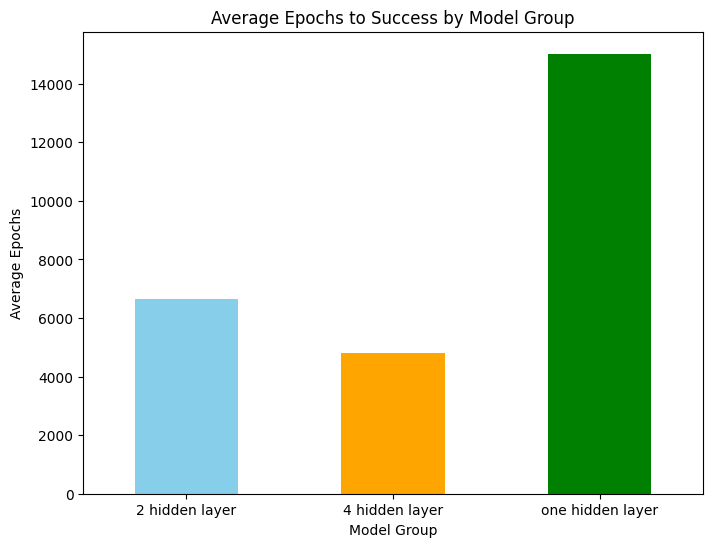

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Define groupings
def assign_group(model):
    if model in ["Model #1", "Model #3", "Model #5", "Model #7"]:
        return "4 hidden layer"
    elif model in ["Model #2", "Model #4", "Model #6", "Model #8"]:
        return "2 hidden layer"
    elif model == "Model #9":
        return "one hidden layer"
    else:
        return "Other"

df_results['group'] = df_results['model'].apply(assign_group)

# Group by the new column and calculate the mean for `avg_epochs`
grouped_data = df_results.groupby("group")["avg_epochs"].mean()

# Plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
grouped_data.plot(kind="bar", color=["skyblue", "orange", "green"])  # Different colors for each group
plt.title("Average Epochs to Success by Model Group")
plt.xlabel("Model Group")
plt.ylabel("Average Epochs")
plt.xticks(rotation=0)
plt.show()



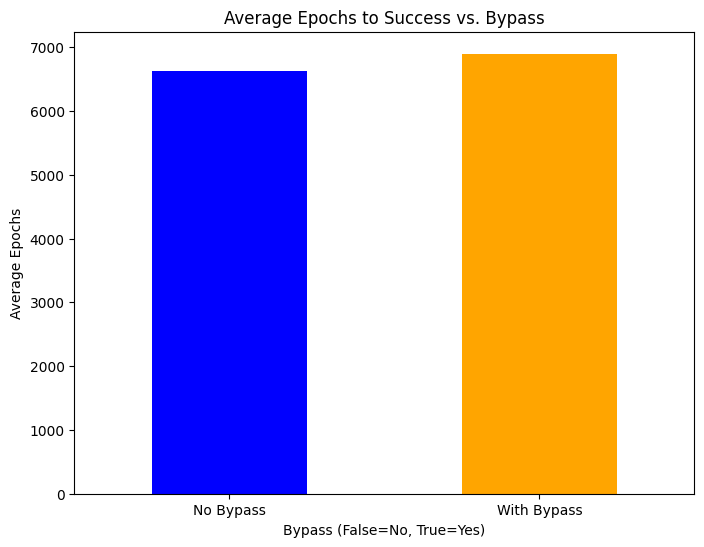

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Define groupings
def assign_group(model):
    if model in ["Model #1", "Model #2", "Model #5", "Model #6"]:
        return "without bypass"
    elif model in ["Model #3", "Model #4", "Model #7", "Model #8", "Model #9"]:
        return "with bypass"
        return "Other"

df_results['group'] = df_results['model'].apply(assign_group)

# Group by the new column and calculate the mean for `avg_epochs`
grouped_data = df_results.groupby("group")["avg_epochs"].mean()

# Plot the data
plt.figure(figsize=(8, 6))
grouped_data.plot(kind="bar", color=["blue", "orange"])
plt.title("Average Epochs to Success vs. Bypass")
plt.xlabel("Bypass (False=No, True=Yes)")
plt.ylabel("Average Epochs")
plt.xticks([0, 1], ["No Bypass", "With Bypass"], rotation=0)
plt.show()


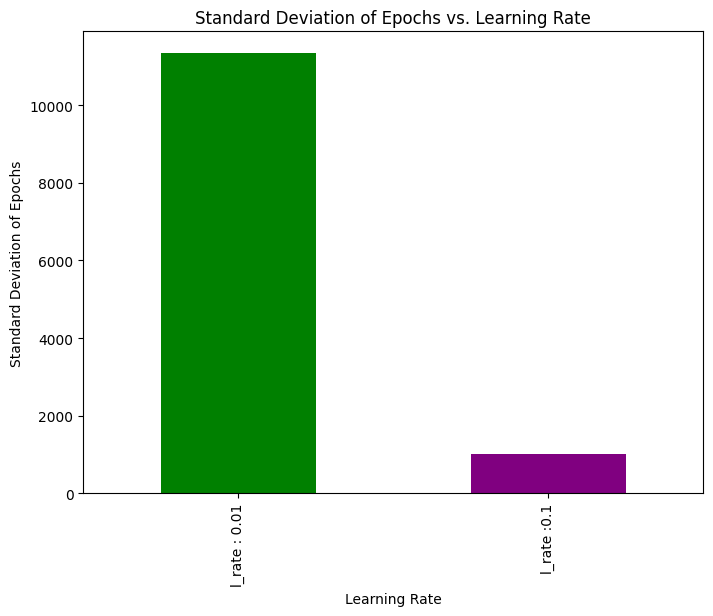

In [25]:
# Define groupings
def assign_group(model):
    if model in ["Model #1", "Model #2", "Model #3", "Model #4"]:
        return "l_rate :0.1"
    elif model in ["Model #5", "Model #6", "Model #7", "Model #8", "Model #9"]:
        return "l_rate : 0.01"
        return "Other"

df_results['group'] = df_results['model'].apply(assign_group)

# Group by the new column and calculate the mean for `avg_epochs`
grouped_data = df_results.groupby("group")["avg_epochs"].mean()


# Plot the data
plt.figure(figsize=(8, 6))
grouped_data.plot(kind="bar", color=["green", "purple"])
plt.title("Standard Deviation of Epochs vs. Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Standard Deviation of Epochs")
plt.show()


סעיף ז4:
During one of our runs, we obtained the following truth table for the hidden neuron's output versus the input values on the training set:

Input: [0. 0.], Hidden Output: [0.2393597]
Input: [0. 1.], Hidden Output: [0.85660154]
Input: [1. 0.], Hidden Output: [0.85646343]
Input: [1. 1.], Hidden Output: [0.9912486]

This indicates that the neural network we built in Model 9 behaves similarly to an OR function.
